In [1]:
# Imports
import random
import time

import cv2
import glob
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
def compare_images(images, mult=3, show_axis=False):
    img_count = len(images)
    fig, axs = plt.subplots(1,img_count, figsize=(mult*img_count, mult))
    i=0
    for title, data in images:
        axs[i].set_title(title, fontsize=14)
        if type(data) == tuple:
            axs[i].bar(data[0], data[1])
        else:
            axs[i].imshow(data.squeeze(), cmap='gray')
            if not show_axis:
                axs[i].axis('off')
        i += 1

In [3]:
cars = glob.glob('./vehicles/**/*.png', recursive=True)
notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)
test_images = glob.glob('./test_images/*.jpg')

np.random.shuffle(cars)
np.random.shuffle(notcars)

In [4]:
print('cars:    ', len(cars))
print('not cars:', len(notcars))

cars:     8792
not cars: 8968


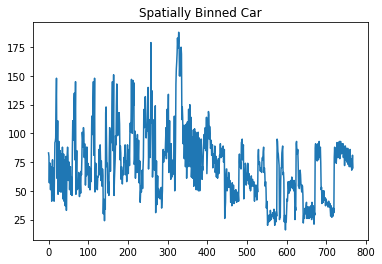

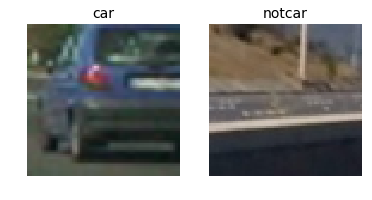

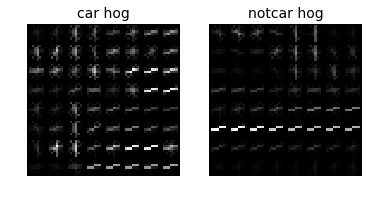

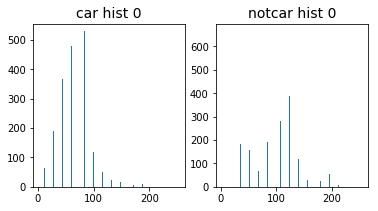

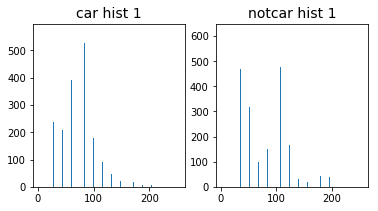

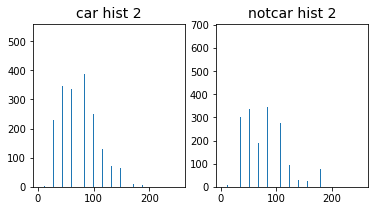

In [5]:
#features
color_space = 'YCrCb'
orientation = 9
px_per_cell = 8
cell_per_block = 2
spatial_size=(16, 16)
hist_bins=32
pix_per_cell=8
hog_channel=0
hist_bins_range=(0,256)

def get_img_in_colorspace(img, colorspace):
    if type(img) == str:
        img = cv2.imread(img)
    if colorspace == 'RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif colorspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif colorspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif colorspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif colorspace == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif colorspace == 'gray':
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img.copy()

def get_hog_features(img, vis=False):
    features = hog(img, orientations=orientation,
                   pixels_per_cell=(px_per_cell, px_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=True, 
                   visualise=vis, feature_vector=True)
    
    return features

def spatial_binning(img):
    return cv2.resize(img, spatial_size).ravel()

def color_histogram(img):
    hist_c1, bins_edges = np.histogram(img[:,:,0], bins=hist_bins, range=hist_bins_range)
    hist_c2, _          = np.histogram(img[:,:,1], bins=hist_bins, range=hist_bins_range)
    hist_c3, _          = np.histogram(img[:,:,2], bins=hist_bins, range=hist_bins_range)
    
    bins_centers = (bins_edges[1:]  + bins_edges[0:len(bins_edges)-1])/2
    hist_features = np.concatenate((hist_c1, hist_c2, hist_c3))
    return hist_features, hist_c1, hist_c2, hist_c3, bins_centers
            
def get_color_hist_and_hog(img):
    return color_histogram(img), get_hog_features(img[:,:,hog_channel], True) 
    
img_car = get_img_in_colorspace(random.choice(cars), 'RGB')
img_notcar = get_img_in_colorspace(random.choice(notcars), 'RGB')
img_car_colorhist, img_car_hog = get_color_hist_and_hog(img_car)
img_notcar_colorhist, img_notcar_hog = get_color_hist_and_hog(img_notcar)

def plot_data(colorhist, i=1):
    return colorhist[4], colorhist[i]

img_lists = [
    [('car', img_car),           ('notcar', img_notcar)],
    [('car hog', img_car_hog[1]),   ('notcar hog', img_notcar_hog[1])],
    [('car hist 0', plot_data(img_car_colorhist, 1)), ('notcar hist 0', plot_data(img_notcar_colorhist, 1))],
    [('car hist 1', plot_data(img_car_colorhist, 2)), ('notcar hist 1', plot_data(img_notcar_colorhist, 2))],
    [('car hist 2', plot_data(img_car_colorhist, 3)), ('notcar hist 2', plot_data(img_notcar_colorhist, 3))],
]

plt.plot(spatial_binning(img_car))
plt.title('Spatially Binned Car')

for img_list in img_lists:
    compare_images(img_list)

In [6]:
def get_img_features(img_data, test=False):
    features = []
    for img_path in img_data:
        img_features = []
        if test:
            img = cv2.cvtColor(img_path, cv2.COLOR_RGB2YCrCb)
        else:
            img = get_img_in_colorspace(img_path, color_space)
        img_features.append(spatial_binning(img))
        img_features.append(color_histogram(img)[0])
        img_features.append(get_hog_features(img[:,:,hog_channel]))
        features.append(np.concatenate(img_features))

    return np.asarray(features)

In [7]:
#sliding window

WINDOW_OVERLAP = (0.5, 0.5)
BOX_COLOR = (255, 0, 0)
BOX_THICKNESS = 6

def slide_window(x_start_stop=None, y_start_stop=None, window_size=None):
    px_per_step_x = np.int(window_size[0]*(1 - WINDOW_OVERLAP[0]))
    px_per_step_y = np.int(window_size[1]*(1 - WINDOW_OVERLAP[1]))
    
    window_count_x = np.int( (x_start_stop[1] - x_start_stop[0]) / px_per_step_x) - 1
    window_count_y = np.int( (y_start_stop[1] - y_start_stop[0]) / px_per_step_y) - 1
    
    window_list = []
    
    for y in range(window_count_y):
        for x in range(window_count_x):
            x_begin = x * px_per_step_x + x_start_stop[0]
            x_end = x_begin + window_size[0]
            
            y_begin = y * px_per_step_y + y_start_stop[0]
            y_end = y_begin + window_size[1]
            
            window_list.append(((x_begin, y_begin), (x_end, y_end)))
            
    return window_list

def draw_boxes(img, boxes):
    img_draw = np.copy(img)
    for box in boxes:
        cv2.rectangle(img_draw, box[0], box[1], BOX_COLOR, BOX_THICKNESS)
    return img_draw

In [8]:
# Get features and scale features
car_features = get_img_features(cars)
notcar_features = get_img_features(notcars)
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_scaler = StandardScaler().fit(X)

In [9]:
scaled_X = X_scaler.transform(X)
scaled_X.shape

(17760, 2628)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(scaled_X, y, test_size=0.2, stratify=y)
len(X_train), len(X_valid)

(14208, 3552)

In [11]:
classifer = LinearSVC()
t = time.time()
classifer.fit(X_train, y_train)
t2 = time.time()
print('Classifier training time: {}'.format(round(t2 - t, 2)))
print('Classifier test set accuracy: {}'.format(round(classifer.score(X_valid, y_valid), 5)))

Classifier training time: 8.48
Classifier test set accuracy: 0.98339


In [12]:
#windows
min_x_range = [500, 1280]
min_y_range = [400, 530]
min_window_size = (80, 80)

# define the maxium window size
max_x_range =[400, 1280]
max_y_range =[400, 700]
max_window_size = (160, 160)

# intermedian windows
num_windows = 4 # the number of total window sizes
x_start_stops = []
y_start_stops = []
window_sizes =[]
# chose the intermediate sizes by interpolation.
def _helper(val1, val2, i):
    return int(val1 + i*(val2-val1)/(num_windows-1))

for i in range(num_windows):
    x_start_stop = [_helper(min_x_range[0], max_x_range[0], i),
                    _helper(min_x_range[1], max_x_range[1], i)]
    
    y_start_stop = [_helper(min_y_range[0], max_y_range[0], i),
                    _helper(min_y_range[1], max_y_range[1], i)]
    
    window_size = [_helper(min_window_size[0], max_window_size[0], i),
                   _helper(min_window_size[1], max_window_size[1], i)]
    
    x_start_stops.append(x_start_stop)
    y_start_stops.append(y_start_stop)
    window_sizes.append(window_size)

print(x_start_stops, '|', y_start_stops, '|', window_sizes)

[[500, 1280], [466, 1280], [433, 1280], [400, 1280]] | [[400, 530], [400, 586], [400, 643], [400, 700]] | [[80, 80], [106, 106], [133, 133], [160, 160]]


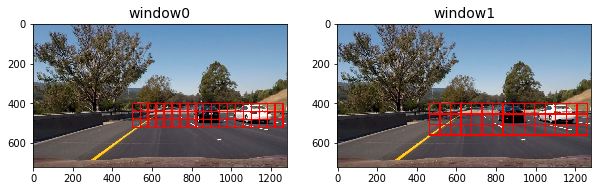

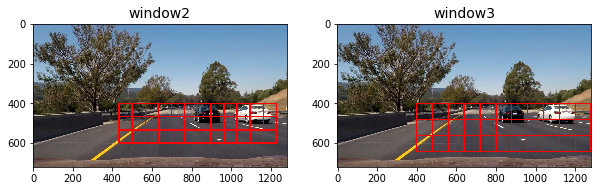

In [13]:
windows = []
img_windows = []
img_test = get_img_in_colorspace('test_images/test6.jpg', 'RGB')
for i in range(num_windows):
    window = slide_window(x_start_stops[i], y_start_stops[i], window_sizes[i])
    windows.append(window)
    img_windows.append(('window'+str(i), draw_boxes(img_test, window)))

compare_images(img_windows[:2], 5, show_axis=True)
compare_images(img_windows[2:], 5, show_axis=True)

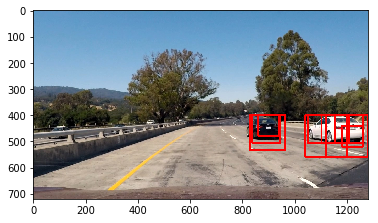

In [14]:
img_test = get_img_in_colorspace('test_images/test1.jpg', 'RGB')
def search_windows(img, grids, classifier, scaler):
    found = []
    for grid in grids:
        for window in grid:
            img_potential = img[window[0][1]:window[1][1], 
                                window[0][0]:window[1][0]]
            img_potential = cv2.resize(img_potential, (64,64))
            features = get_img_features([img_potential], True)[0]
            X_features = scaler.transform(np.array(features).reshape(1, -1))
            prediction = classifier.predict(X_features)
            if prediction == 1:
                found.append(window)
    
    return found

found_windows = search_windows(img_test, windows, classifer, X_scaler)
img_window = draw_boxes(img_test, found_windows)                    

plt.imshow(img_window)

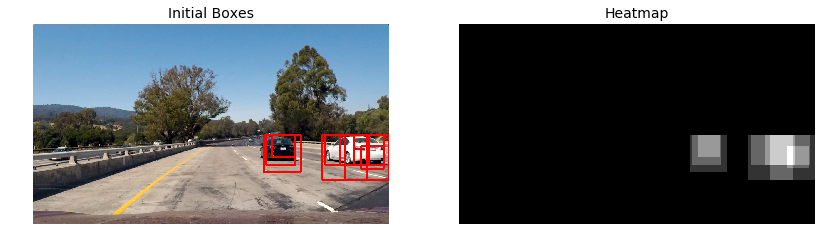

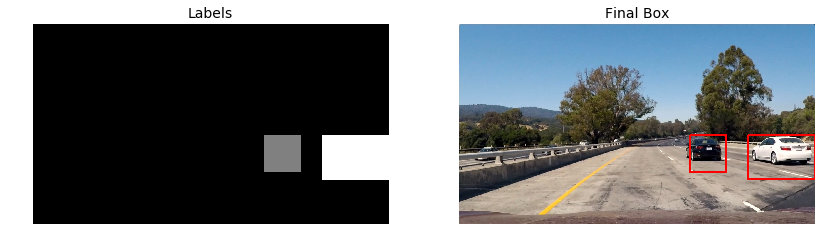

In [15]:
def apply_threshold(heatmap, threshold=1):
    '''Zero out heatmap pixels below the threshold and return thresholded heatmap'''
    new_heatmap = np.copy(heatmap)
    new_heatmap[new_heatmap < threshold] = 0

    return new_heatmap

def get_heatmap(img_test, bbox_list):
    '''Add "heat" to a map for a list of bounding boxes'''
    heatmap = np.zeros_like(img_test[:,:,0]).astype(np.float)
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return apply_threshold(heatmap)

# define a function to find bounding box of the labels
def find_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_img = np.copy(img)
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # append the bounding box to a list
        bboxes.append(bbox)
    # Return the bounding boxes
    return bboxes


# inicalize heat map
def find_cars(img_test, vis=False):
    found_windows = search_windows(img_test, windows, classifer, X_scaler)
    img_window = draw_boxes(img_test, found_windows)      
    heatmap = get_heatmap(img_test, found_windows)
    labels = label(heatmap)
    bboxes = find_labeled_bboxes(img_test, labels)
    img_box_final = draw_boxes(img_test, bboxes)

    if not vis:
        return img_box_final
    
#     print(labels[1], 'cars found')
    compare_images([('Initial Boxes', img_window), ('Heatmap', heatmap)], 7)
    compare_images([('Labels', labels[0]), ('Final Box', img_box_final)], 7)

find_cars(img_test, True)

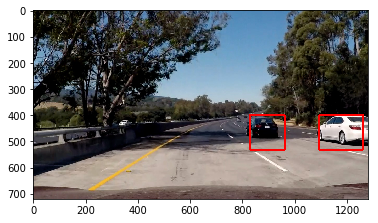

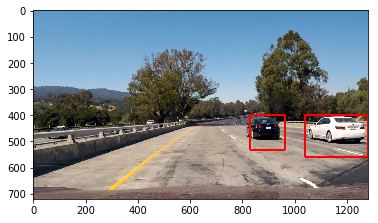

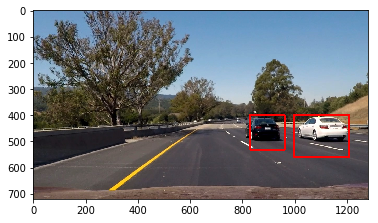

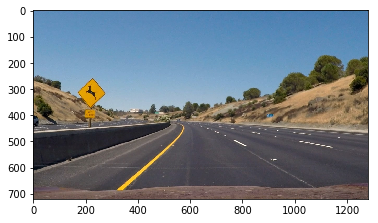

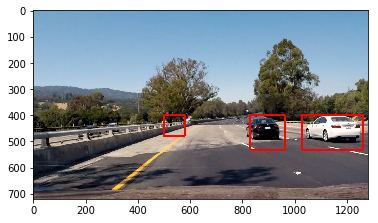

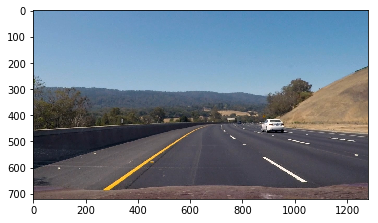

In [16]:
for img_path in test_images:
    img_test = get_img_in_colorspace(img_path, 'RGB')
    heatmap = find_cars(img_test)
    plt.figure()
    plt.imshow(heatmap)

In [17]:
previous_heatmap = None
def find_cars_pipeline(img):
    global previous_heatmap
    found_windows = search_windows(img, windows, classifer, X_scaler)
    img_window = draw_boxes(img, found_windows)      
    heatmap = get_heatmap(img, found_windows)
    current_heatmap = heatmap.copy()
    if previous_heatmap is not None:
        heatmap = np.minimum(heatmap, previous_heatmap)
    previous_heatmap = current_heatmap
    labels = label(heatmap)
    bboxes = find_labeled_bboxes(img, labels)
    img_final = draw_boxes(img, bboxes)
    return img_final

In [18]:
video_clip = VideoFileClip("project_video.mp4").fl_image(find_cars_pipeline) 
output = 'project_video_result.mp4'
%time video_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [06:36<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 6min 34s, sys: 1.89 s, total: 6min 35s
Wall time: 6min 37s
